## Substitution Effect

The **substitution effect** occurs when two features share predictive information. This effect can bias the results of feature importance methods. In the case of **MDI** (Mean Decrease in Impurity), the importance of the two identical features may be halved because they are randomly selected with the same probability. In the case of **MDA** (Mean Decrease in Accuracy), the effect of shuffling one feature may be compensated for by the effect of another feature, leading to the possibility that two equally important features are considered **unimportant**.

In [1]:
import pandas as pd
import numpy as np

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

In [2]:
trnsX, cont = get_test_data(
    n_features = 20, 
    n_informative = 5, 
    n_redundant = 5, 
    n_samples = 1000
)

### Clustered Feature Importance
### **Clustered Feature Importance**  

Clustered Feature Importance is an alternative approach to analyzing feature importance that eliminates the need for **baseline shifts**. This method involves **clustering similar features** and applying feature importance analysis at the **cluster level**, thereby mitigating the **substitution effect** (i.e., when two features provide overlapping information and reduce each other’s importance). This approach often leads to **more intuitive results** since it focuses on feature groupings rather than individual features.

---

### **Steps of the Clustered Feature Importance Algorithm**

1. **Identify the Number and Composition of Feature Clusters**  
   - Use clustering algorithms such as **K-means, hierarchical clustering**, or **spectral clustering** to group similar features based on statistical similarity or correlation.  
   - The goal is to form **non-overlapping clusters**, ensuring that each cluster contains features with related information.

2. **Apply Feature Importance Analysis to Clusters Instead of Individual Features**  
   - Once the clusters are formed, the model computes **feature importance scores** at the **cluster level** rather than for each individual feature.  
   - This aggregation reduces redundancy among features within clusters, making the results easier to interpret.  

---

### **Benefits of Clustered Feature Importance**  

- **Reduces Redundancy:** By analyzing importance at the group level, the method alleviates the substitution effect, which can occur when features provide overlapping information.
- **Intuitive Interpretation:** Since the analysis focuses on groups of similar features, the results are often more aligned with domain intuition and easier to communicate.
- **No Baseline Shift Required:** Unlike Shapley values, which involve computing contributions against a baseline, Clustered Feature Importance works directly on feature partitions, simplifying the analysis.

---

### **Example Workflow**

1. **Cluster Identification**  
   Use hierarchical clustering to group features based on correlations:

   ```python
   from sklearn.cluster import AgglomerativeClustering
   from scipy.spatial.distance import pdist, squareform
   import numpy as np

   # Compute the correlation matrix and distance matrix
   corr_matrix = np.corrcoef(X.T)
   dist_matrix = squareform(1 - corr_matrix)

   # Perform clustering
   clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
   clusters = clustering.fit_predict(dist_matrix)
   ```

2. **Cluster-Level Feature Importance**  
   Aggregate the features within each cluster and compute their collective importance:

   ```python
   import shap

   # Train a model
   model = xgb.XGBRegressor().fit(X, y)

   # Create SHAP explainer and compute cluster-level importance
   explainer = shap.Explainer(model, X)

   for cluster_id in np.unique(clusters):
       cluster_features = X[:, clusters == cluster_id]
       shap_values = explainer(cluster_features)
       shap.summary_plot(shap_values, cluster_features, feature_names=X.columns[clusters == cluster_id])
   ```

---

### **Conclusion**  

Clustered Feature Importance provides a **more robust and interpretable** way to analyze feature importance by working at the cluster level. This method ensures that overlapping features do not mask each other's importance and delivers **intuitive insights** without the complexity of baseline shifts. It is particularly useful for datasets with many correlated features.

#### Clustered Mean Decrease Importance

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

#### Clustered Mean Decrease Accuracy

In [7]:
def group_mean_std(df0, clstrs) -> pd.DataFrame :
    out = pd.DataFrame(columns = ['mean','std'])
    for i, j in clstrs.items() :
        df1 = df0[j].sum(axis = 1)
        out.loc['C_' + str(i), 'mean'] = df1.mean()
        out.loc['C_' + str(i), 'std'] = df1.std() * df1.shape[0] ** (-0.5)
    return out

def clustered_mean_decrease_importance(fit, feature_names, clstrs) -> pd.DataFrame :
    df0 = {
        i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient = 'index')
    df0.columns = feature_names
    df0 = df0.replace(0, np.nan)
    imp = group_mean_std(df0, clstrs)
    imp /= imp['mean'].sum()
    return imp

In [8]:
from quant_free.finml.machine_learning.clustering import clusterKMeansBase
corr0, clusters, silh = clusterKMeansBase(trnsX.corr(), maxNumClusters = 10, n_init = 10)

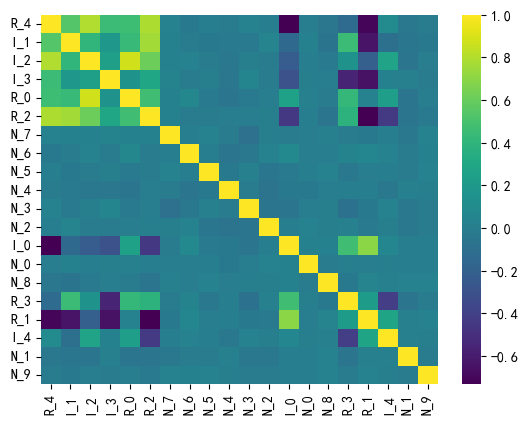

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr0, cmap = 'viridis')
plt.show()

In [10]:
c_mdi = clustered_mean_decrease_importance(fit, trnsX.columns, clstrs = clusters)

In [11]:
c_mdi

,mean,std
C_0,0.351261,0.003162
C_1,0.648739,0.003162
